In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelBinarizer, LabelEncoder
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    f1_score, roc_auc_score, plot_confusion_matrix,
    accuracy_score, classification_report
)

from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.combine import SMOTETomek

In [2]:
def nestedCV(estimator, param_grid, x_train, y_train, inner_cv, outer_cv,
             **kwargs):
    n_jobs = kwargs.get('n_jobs', 6)
    scoring = kwargs.get('scoring', 'f1')
    verbose = kwargs.get('verbose', 0)
    name = kwargs.get('name')
    results = list()
    x_train = x_train
    binarizer = LabelBinarizer()

    for train, val in outer_cv.split(x_train, y_train):
        search = GridSearchCV(estimator,
                              param_grid,
                              cv=inner_cv,
                              scoring=scoring,
                              n_jobs=n_jobs,
                              verbose=verbose,
                              refit=True).fit(x_train[train],
                                              y_train[train])
        y_pred = search.predict(x_train[val])
        result = search.best_params_
        result['name'] = name
        result['f1_score'] = f1_score(y_train[val], y_pred, average = "macro")
        result['inner_score'] = search.best_score_
        result['auc'] = roc_auc_score(
                binarizer.fit_transform(y_train[val]),
                binarizer.fit_transform(y_pred),
                average = "macro", multi_class = 'ovr')
        result['accuracy'] = accuracy_score(y_train[val], y_pred)
        results.append(result)

    aggregate = pd.DataFrame(results).groupby(list(param_grid.keys()) +
                                              ['name'],
                                              as_index=False)
    table = aggregate.mean()
    table['count'] = aggregate.count().f1_score

    best_params = {
        k: v
        for k, v in table.sort_values(
            ['f1_score'], ascending=False).iloc[0].to_dict().items()
        if k in param_grid.keys()
    }

    return table, best_params

In [3]:
train = pd.concat([
    pd.read_pickle("../data/datasets/train_classic.pkl"),
    pd.read_pickle("../data/datasets/val_classic.pkl")
])
test = pd.read_pickle("../data/datasets/test_classic.pkl")

In [4]:
encoder = LabelEncoder()

In [5]:
cv_inner = StratifiedKFold(n_splits = 3, shuffle = True, random_state = 42069)
cv_outer = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42069)

In [6]:
x_train = train.tweet.to_numpy()
x_test = test.tweet.to_numpy()

y_train = encoder.fit_transform(train.label)
y_test = test.label

# Entrainement
## Modèle avec Standard Scaler

In [7]:
model_1 = Pipeline([
    ('vect', TfidfVectorizer(
        sublinear_tf = True, max_df = 0.5,
        stop_words = None)),
    ('preprocess', StandardScaler(with_mean = False)),
    ('clf', SGDClassifier(
        early_stopping = True,
        n_iter_no_change = 6,
        penalty = 'l2',
        max_iter = 3000
    ))
])

In [8]:
grid_1 = {
    'clf__loss': ['hinge', 'log', 'modified_huber'],
    'clf__learning_rate': ['invscaling', 'optimal'],
    'clf__eta0': [.01, .001],
    'clf__alpha': [1e-2, 1e-4]
}

In [9]:
results_1, params_1 = nestedCV(
    model_1, grid_1, x_train, y_train,
    cv_inner, cv_outer, name = "Sd_SGDClassifier",
    scoring = 'f1_macro'
)

In [10]:
results_1

,clf__loss,clf__learning_rate,clf__eta0,clf__alpha,name,f1_score,inner_score,auc,accuracy,count
0,hinge,invscaling,0.010,0.0001,Sd_SGDClassifier,0.523612,0.511313,0.691406,0.650781,1
1,modified_huber,invscaling,0.001,0.0001,Sd_SGDClassifier,0.519098,0.520651,0.669877,0.656890,2
2,modified_huber,invscaling,0.001,0.0100,Sd_SGDClassifier,0.518021,0.518131,0.670298,0.651036,2


## Modèle sans standardisation

In [11]:
model_2 = Pipeline([
    ('vect', TfidfVectorizer(
        sublinear_tf = True, max_df = 0.5,
        stop_words = None)),
    ('clf', SGDClassifier(
        early_stopping = True,
        n_iter_no_change = 6,
        penalty = 'l2',
        max_iter = 3000
    ))
])

In [12]:
grid_2 = {
    'clf__loss': ['hinge', 'log', 'modified_huber'],
    'clf__learning_rate': ['invscaling', 'optimal'],
    'clf__eta0': [.01, .001, 1e-100],
    'clf__alpha': [1e-2, 1e-4, 1e-5]
}

In [13]:
results_2, params_2 = nestedCV(
    model_2, grid_2, x_train, y_train,
    cv_inner, cv_outer, name = "SGDClassifier",
    scoring = 'f1_macro'
)

In [14]:
results_2

,clf__loss,clf__learning_rate,clf__eta0,clf__alpha,name,f1_score,inner_score,auc,accuracy,count
0,hinge,optimal,1.000000e-100,0.00001,SGDClassifier,0.582424,0.583338,0.715422,0.669273,1
1,hinge,optimal,1.000000e-03,0.00010,SGDClassifier,0.629941,0.559474,0.727996,0.721094,1
2,hinge,optimal,1.000000e-02,0.00010,SGDClassifier,0.580161,0.583668,0.703173,0.706916,2
3,log,optimal,1.000000e-03,0.00001,SGDClassifier,0.513476,0.592333,0.664370,0.680469,1


## Modèle avec sur-échantillonnage

In [15]:
model_3 = ImbPipeline([
    ('vect', TfidfVectorizer(
        sublinear_tf = True, max_df = 0.5,
        stop_words = None)),
    ('aug', RandomOverSampler(random_state = 42069)),
    ('clf', SGDClassifier(
        early_stopping = True,
        n_iter_no_change = 6,
        penalty = 'l2',
        max_iter = 3000
    ))
])

In [16]:
grid_3 = {
    'clf__loss': ['hinge', 'log', 'modified_huber'],
    'clf__learning_rate': ['invscaling', 'optimal'],
    'clf__eta0': [.01, .001, 1e-100],
    'clf__alpha': [1e-2, 1e-4, 1e-5]
}

In [17]:
results_3, params_3 = nestedCV(
    model_3, grid_3, x_train, y_train,
    cv_inner, cv_outer, name = "ROS_SGDClassifier",
    scoring = 'f1_macro'
)

In [18]:
results_3

,clf__loss,clf__learning_rate,clf__eta0,clf__alpha,name,f1_score,inner_score,auc,accuracy,count
0,hinge,optimal,1.000000e-02,0.00010,ROS_SGDClassifier,0.528270,0.589074,0.692098,0.681250,1
1,log,optimal,1.000000e-100,0.00001,ROS_SGDClassifier,0.596063,0.599029,0.735687,0.681001,1
2,log,optimal,1.000000e-03,0.00001,ROS_SGDClassifier,0.592342,0.607160,0.728046,0.704688,1
3,log,optimal,1.000000e-02,0.00001,ROS_SGDClassifier,0.593769,0.572633,0.735584,0.689718,2


## Modèle avec SMOTE

In [19]:
model_4 = ImbPipeline([
    ('vect', TfidfVectorizer(
        sublinear_tf = True, max_df = 0.5,
        stop_words = None)),
    ('aug', SMOTE(random_state = 42069, n_jobs = -1)),
    ('clf', SGDClassifier(
        early_stopping = True,
        n_iter_no_change = 6,
        penalty = 'l2',
        max_iter = 3000
    ))
])

In [28]:
grid_4 = {
    'aug__k_neighbors': [5, 10, 15, 25],
    'clf__loss': ['hinge', 'log', 'modified_huber'],
    'clf__learning_rate': ['invscaling', 'optimal'],
    'clf__eta0': [.01, .001, 1e-100],
    'clf__alpha': [1e-2, 1e-4, 1e-5]
}

In [29]:
results_4, params_4 = nestedCV(
    model_4, grid_4, x_train, y_train,
    cv_inner, cv_outer, name = "SMOTE_SGDClassifier",
    scoring = 'f1_macro'
)

In [30]:
results_4

,aug__k_neighbors,clf__loss,clf__learning_rate,clf__eta0,clf__alpha,name,f1_score,inner_score,auc,accuracy,count
0,5,log,optimal,1.000000e-100,0.00001,SMOTE_SGDClassifier,0.561657,0.594661,0.709538,0.686719,1
1,5,log,optimal,1.000000e-03,0.00001,SMOTE_SGDClassifier,0.603359,0.600421,0.738723,0.688038,1
2,10,log,optimal,1.000000e-100,0.00001,SMOTE_SGDClassifier,0.592570,0.613417,0.731044,0.703125,1
3,15,log,optimal,1.000000e-100,0.00001,SMOTE_SGDClassifier,0.607808,0.577312,0.750511,0.701562,1
4,15,log,optimal,1.000000e-03,0.00001,SMOTE_SGDClassifier,0.601785,0.582724,0.734275,0.690383,1


## Modèle avec SMOTE et nettoyage avec les liens de Tomek

In [23]:
model_5 = ImbPipeline([
    ('vect', TfidfVectorizer(
        sublinear_tf = True, max_df = 0.5,
        stop_words = None)),
    ('aug', SMOTETomek(random_state = 42069, n_jobs = -1)),
    ('clf', SGDClassifier(
        early_stopping = True,
        n_iter_no_change = 6,
        penalty = 'l2',
        max_iter = 3000
    ))
])

In [24]:
grid_5 = {
    'clf__loss': ['hinge', 'log', 'modified_huber'],
    'clf__learning_rate': ['invscaling', 'optimal'],
    'clf__eta0': [.01, .001, 1e-100],
    'clf__alpha': [1e-2, 1e-4, 1e-5]
}

In [25]:
results_5, params_5 = nestedCV(
    model_5, grid_5, x_train, y_train,
    cv_inner, cv_outer, name = "SMOTETomek_SGDClassifier",
    scoring = 'f1_macro'
)

In [26]:
results_5

,clf__loss,clf__learning_rate,clf__eta0,clf__alpha,name,f1_score,inner_score,auc,accuracy,count
0,log,optimal,1.000000e-100,0.00001,SMOTETomek_SGDClassifier,0.609440,0.580918,0.737351,0.716185,1
1,log,optimal,1.000000e-02,0.00001,SMOTETomek_SGDClassifier,0.589285,0.584020,0.728459,0.689499,3
2,modified_huber,optimal,1.000000e-03,0.00010,SMOTETomek_SGDClassifier,0.553195,0.607964,0.705004,0.692187,1


# Performances sur les sets de validation
## Top 5 par rapport au F1-score

In [34]:
pd.concat([results_1, results_2, results_3, results_4, results_5]).sort_values(by=['f1_score'], ascending=False)[:5]

,clf__loss,clf__learning_rate,clf__eta0,clf__alpha,name,f1_score,inner_score,auc,accuracy,count,aug__k_neighbors
1,hinge,optimal,1.000000e-03,0.00010,SGDClassifier,0.629941,0.559474,0.727996,0.721094,1,NaN
0,log,optimal,1.000000e-100,0.00001,SMOTETomek_SGDClassifier,0.609440,0.580918,0.737351,0.716185,1,NaN
3,log,optimal,1.000000e-100,0.00001,SMOTE_SGDClassifier,0.607808,0.577312,0.750511,0.701562,1,15.0
1,log,optimal,1.000000e-03,0.00001,SMOTE_SGDClassifier,0.603359,0.600421,0.738723,0.688038,1,5.0
4,log,optimal,1.000000e-03,0.00001,SMOTE_SGDClassifier,0.601785,0.582724,0.734275,0.690383,1,15.0


## Top 5 par rapport à l'AUC

In [33]:
pd.concat([results_1, results_2, results_3, results_4, results_5]).sort_values(by=['auc'], ascending=False)[:5]

,clf__loss,clf__learning_rate,clf__eta0,clf__alpha,name,f1_score,inner_score,auc,accuracy,count,aug__k_neighbors
3,log,optimal,1.000000e-100,0.00001,SMOTE_SGDClassifier,0.607808,0.577312,0.750511,0.701562,1,15.0
1,log,optimal,1.000000e-03,0.00001,SMOTE_SGDClassifier,0.603359,0.600421,0.738723,0.688038,1,5.0
0,log,optimal,1.000000e-100,0.00001,SMOTETomek_SGDClassifier,0.609440,0.580918,0.737351,0.716185,1,NaN
1,log,optimal,1.000000e-100,0.00001,ROS_SGDClassifier,0.596063,0.599029,0.735687,0.681001,1,NaN
3,log,optimal,1.000000e-02,0.00001,ROS_SGDClassifier,0.593769,0.572633,0.735584,0.689718,2,NaN


# Evaluation des deux meilleurs modèles
## Simple SGD

In [74]:
binarizer = LabelBinarizer()

In [36]:
final_model_1 = Pipeline([
    ('vect', TfidfVectorizer(
        sublinear_tf = True, max_df = 0.5,
        stop_words = None)),
    ('clf', SGDClassifier(
        loss = 'hinge',
        learning_rate = 'optimal',
        alpha = 1e-4,
        early_stopping = True,
        n_iter_no_change = 6,
        penalty = 'l2',
        max_iter = 3000
    ))
])

final_model_1.fit(x_train, y_train)

Pipeline(steps=[('vect', TfidfVectorizer(max_df=0.5, sublinear_tf=True)),
                ('clf',
                 SGDClassifier(early_stopping=True, max_iter=3000,
                               n_iter_no_change=6))])

In [76]:
y_pred = final_model_1.predict(x_test)

print(classification_report(
    y_test,
    encoder.inverse_transform(y_pred)
))

              precision    recall  f1-score   support

     EMOTION       0.57      0.36      0.44       337
 INFORMATION       0.61      0.86      0.72      1473
     OPINION       0.55      0.56      0.55       950
   SENTIMENT       0.47      0.03      0.05       523

    accuracy                           0.59      3283
   macro avg       0.55      0.45      0.44      3283
weighted avg       0.57      0.59      0.53      3283



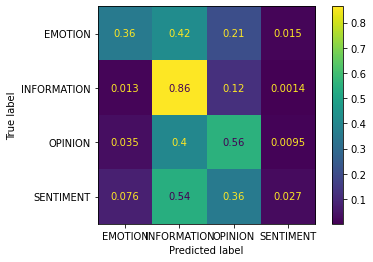

In [77]:
plot_confusion_matrix(
    final_model_1,
    x_test, encoder.transform(y_test),
    display_labels = encoder.classes_,
    normalize = 'true'
)

In [78]:
print("F1-score: {}\nAUC: {}\nAccuracy: {}".format(
    f1_score(y_test, encoder.inverse_transform(y_pred), average = "macro"),
    roc_auc_score(binarizer.fit_transform(y_test), binarizer.transform(encoder.inverse_transform(y_pred)), average = "macro", multi_class = "ovr"),
    accuracy_score(y_test, encoder.inverse_transform(y_pred))
))

F1-score: 0.43919626478822693
AUC: 0.6418289252067279
Accuracy: 0.5893999390801097


## SGD avec SMOTE

In [71]:
final_model_2 = ImbPipeline([
    ('vect', TfidfVectorizer(
        sublinear_tf = True, max_df = 0.5,
        stop_words = None)),
    ('aug', SMOTE(
        k_neighbors = 15,
        random_state = 42069,
        n_jobs = -1)),
    ('clf', SGDClassifier(
        loss = 'log',
        learning_rate = 'optimal',
        alpha = 1e-5,
        early_stopping = True,
        n_iter_no_change = 6,
        penalty = 'l2',
        max_iter = 100
    ))
])

final_model_2.fit(x_train, y_train)

Pipeline(steps=[('vect', TfidfVectorizer(max_df=0.5, sublinear_tf=True)),
                ('aug', SMOTE(k_neighbors=15, n_jobs=-1, random_state=42069)),
                ('clf',
                 SGDClassifier(alpha=1e-05, early_stopping=True, loss='log',
                               max_iter=100, n_iter_no_change=6))])

In [72]:
y_pred = final_model_2.predict(x_test)

print(classification_report(
    y_test,
    encoder.inverse_transform(y_pred)
))

              precision    recall  f1-score   support

     EMOTION       0.45      0.47      0.46       337
 INFORMATION       0.65      0.80      0.72      1473
     OPINION       0.53      0.60      0.56       950
   SENTIMENT       0.43      0.04      0.07       523

    accuracy                           0.59      3283
   macro avg       0.51      0.48      0.45      3283
weighted avg       0.56      0.59      0.54      3283



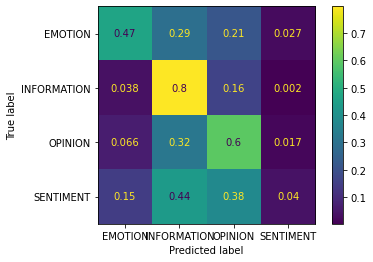

In [73]:
plot_confusion_matrix(
    final_model_2,
    x_test, encoder.transform(y_test),
    display_labels = encoder.classes_,
    normalize = 'true'
)

In [75]:
print("F1-score: {}\nAUC: {}\nAccuracy: {}".format(
    f1_score(y_test, encoder.inverse_transform(y_pred), average = "macro"),
    roc_auc_score(binarizer.fit_transform(y_test), binarizer.transform(encoder.inverse_transform(y_pred)), average = "macro", multi_class = "ovr"),
    accuracy_score(y_test, encoder.inverse_transform(y_pred))
))

F1-score: 0.4516235519906816
AUC: 0.65737977001712
Accuracy: 0.5851355467560159
